<a href="https://colab.research.google.com/github/surajK610/AI/blob/master/Time_Series_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuralprophet
!pip install pmdarima

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing and Selection Tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, mean_absolute_percentage_error

# Basc Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error

# Transformations if necessary
from scipy.special import boxcox1p
from numpy import log, log1p

# Time Series Specific Tools
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from neuralprophet import NeuralProphet
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL

import warnings
warnings.filterwarnings(action='ignore')

In [57]:
df = pd.read_csv('index.csv', parse_dates={'Date': ['Year', 'Month', 'Day']}, index_col='Date')

In [13]:
for col in df.columns:
  print(col, df[col].isnull().sum()/len(df[col]))

Federal Funds Target Rate 0.4889380530973451
Federal Funds Upper Target 0.8860619469026548
Federal Funds Lower Target 0.8860619469026548
Effective Federal Funds Rate 0.168141592920354
Real GDP (Percent Change) 0.7234513274336283
Unemployment Rate 0.168141592920354
Inflation Rate 0.21460176991150443


(array([ 44.,  51.,  84., 101., 187.,  75., 105.,  45.,  39.,  21.]),
 array([1.22377543, 1.3393525 , 1.45492957, 1.57050664, 1.68608371,
        1.80166078, 1.91723785, 2.03281492, 2.14839199, 2.26396906,
        2.37954613]),
 <BarContainer object of 10 artists>)

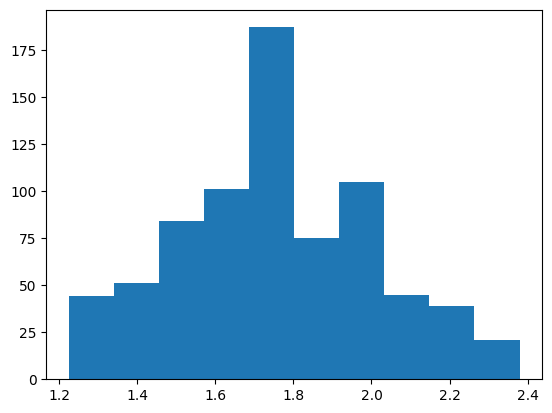

In [237]:
plt.hist(df['Unemployment Rate'].apply(log), label='Inflation Rate')
## growth rate as exponential change

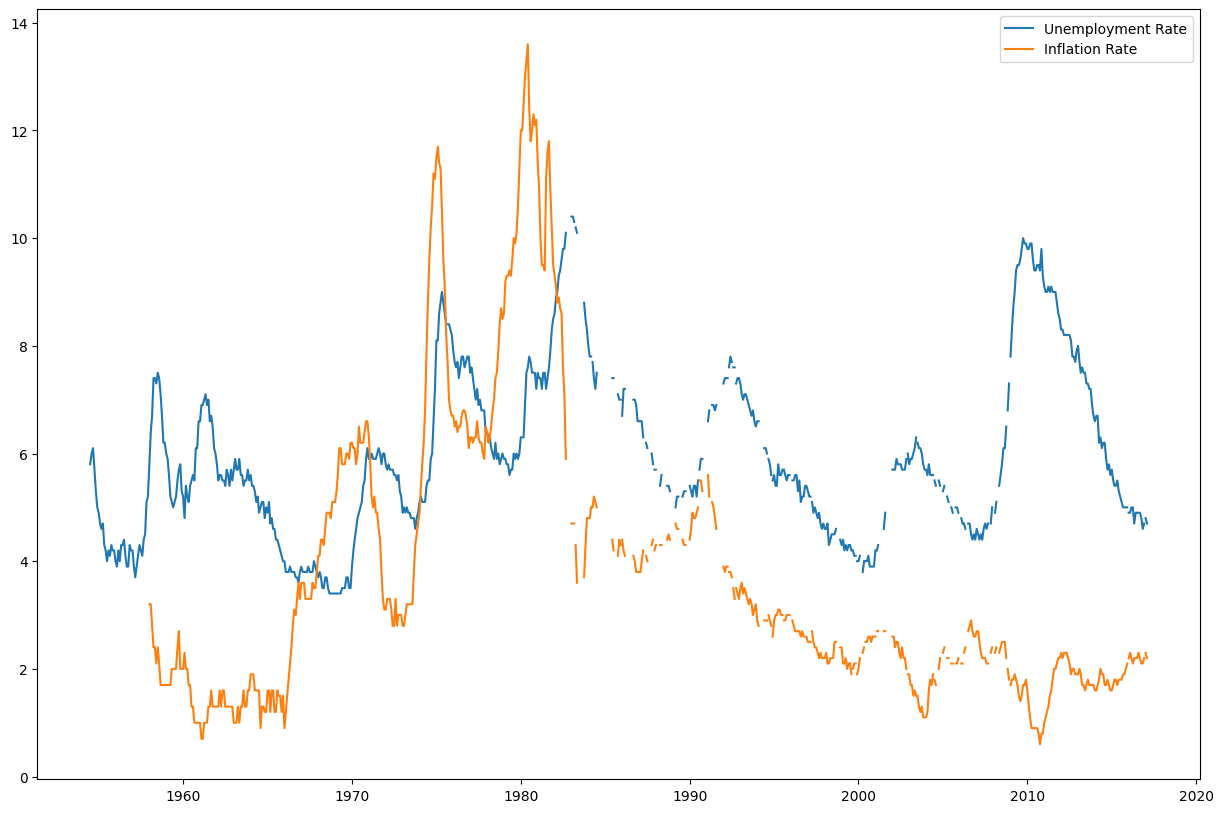

In [17]:
## Let's check Unemployment Rate + Inflation Rate
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(df['Unemployment Rate'], label='Unemployment Rate')
ax.plot(df['Inflation Rate'], label='Inflation Rate')
ax.legend()

Looks like inflation and unemployment rate might have a relationship where unemployment sometimes follows inflation

In [20]:

df['Unemployment Rate'].interpolate(method='linear', limit_direction='both')

Date
1954-07-01    5.80
1954-08-01    6.00
1954-09-01    6.10
1954-10-01    5.70
1954-11-01    5.30
              ... 
2016-12-14    4.75
2017-01-01    4.80
2017-02-01    4.70
2017-03-01    4.70
2017-03-16    4.70
Name: Unemployment Rate, Length: 904, dtype: float64

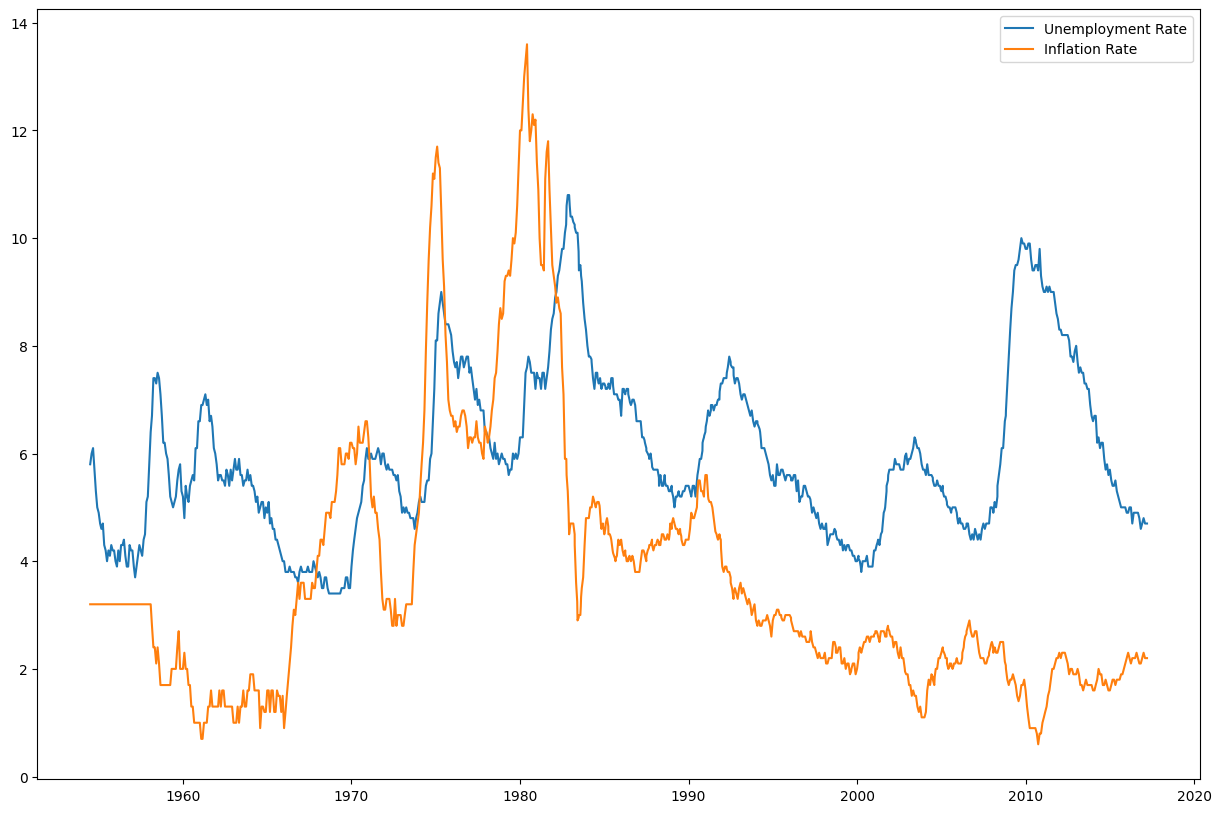

In [21]:
## Imputation
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(df['Unemployment Rate'].interpolate(method='linear', limit_direction='both'), label='Unemployment Rate')
ax.plot(df['Inflation Rate'].interpolate(method='linear', limit_direction='both'), label='Inflation Rate')
ax.legend()

As we can assume continuity, this actually looks pretty good for imputation of the missing values. Let's locate seasonal, trend, and autoregressive effects

In [225]:
unempl_df = df['Unemployment Rate'].interpolate('linear').apply(log1p)

In [226]:
## some baselines
time_feature = DeterministicProcess(index=unempl_df.index, order=1)
X = time_feature.in_sample()
X_train, X_test, y_train, y_test = train_test_split(X, unempl_df,
                                                    train_size=0.80,
                                                    shuffle=False)

lr_time = LinearRegression().fit(X_train, y_train)
lr_preds = lr_time.predict(X_test)
print('Time Order 1 Score', lr_time.score(lr_preds[:, np.newaxis], y_test))

X = pd.DataFrame({'lag1': unempl_df.shift(1, fill_value=unempl_df.mean())})
X_train, X_test, y_train, y_test = train_test_split(X, unempl_df,
                                                    train_size=0.80,
                                                    shuffle=False)
lr_time = LinearRegression().fit(X_train, y_train)
lr_preds = lr_time.predict(X_test)
print('AR Order 1 Score', lr_time.score(lr_preds[:, np.newaxis], y_test))

Time Order 1 Score -0.1395852905550088
AR Order 1 Score 0.9922792337907248


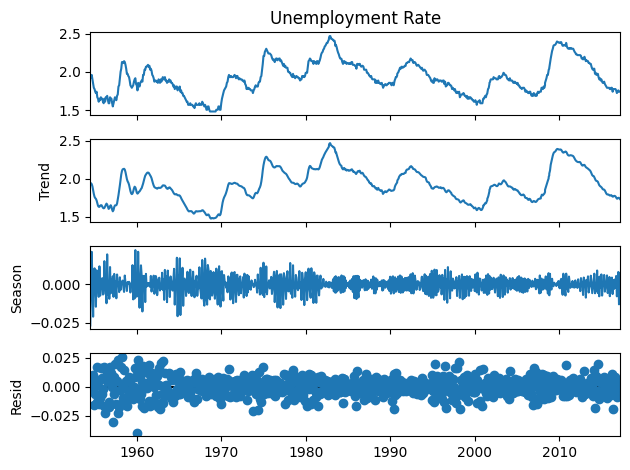

In [227]:
stl = STL(unempl_df, seasonal=7, period=4, trend=5) #
res = stl.fit()
fig = res.plot()

Nothing useful as does not nicely decompose into season and trend at all

## LagPlots as Autoregressive Features Seem Super Useful

In [228]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

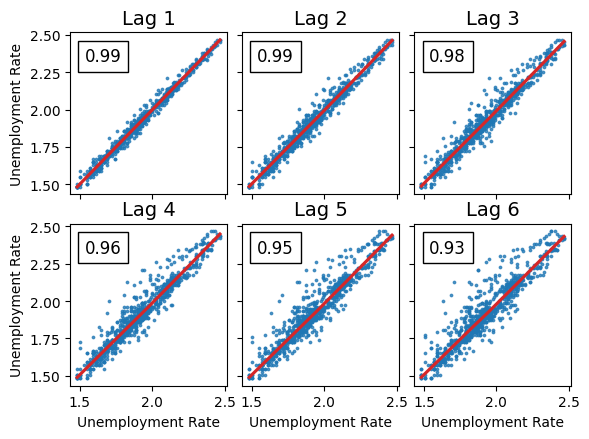

In [229]:
_ = plot_lags(unempl_df, lags=6, nrows=2)

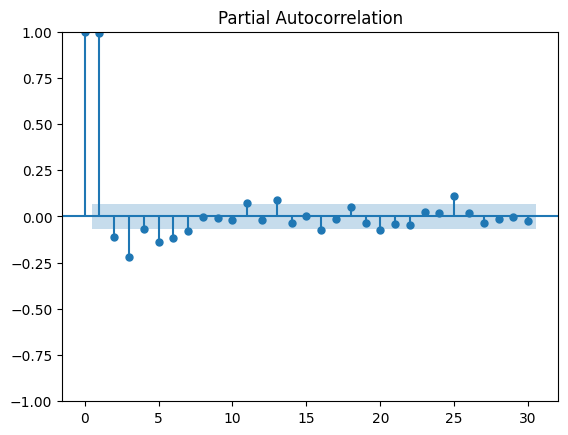

In [230]:
_ = plot_pacf(unempl_df)

Seems like a dependence on 1, 2, 3, 4, 5 are useful so let's use these

In [231]:
## dependence on 1, 2, 3, 4, 5 useful it seems

In [ ]:
auto_arima(unempl_df, seasonal=True, m=12, trace=True).summary()

In [233]:
RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
MAPE = mean_absolute_percentage_error

In [234]:
order, seasonal_order = (2,1,2), (1,0,1,12)
train, test = unempl_df[:'2010'], unempl_df['2010':]

sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = sarima.fit()
y_pred = fit_sarima.forecast(len(test))

err = RMSLE(test, y_pred)
err_mape = MAPE(test, y_pred)

In [235]:
print('RMSLE SARIMAX', err)
print('MAPE SARIMAX', err_mape)

RMSLE SARIMAX 0.07646901269950782
MAPE SARIMAX 0.09400075654960628


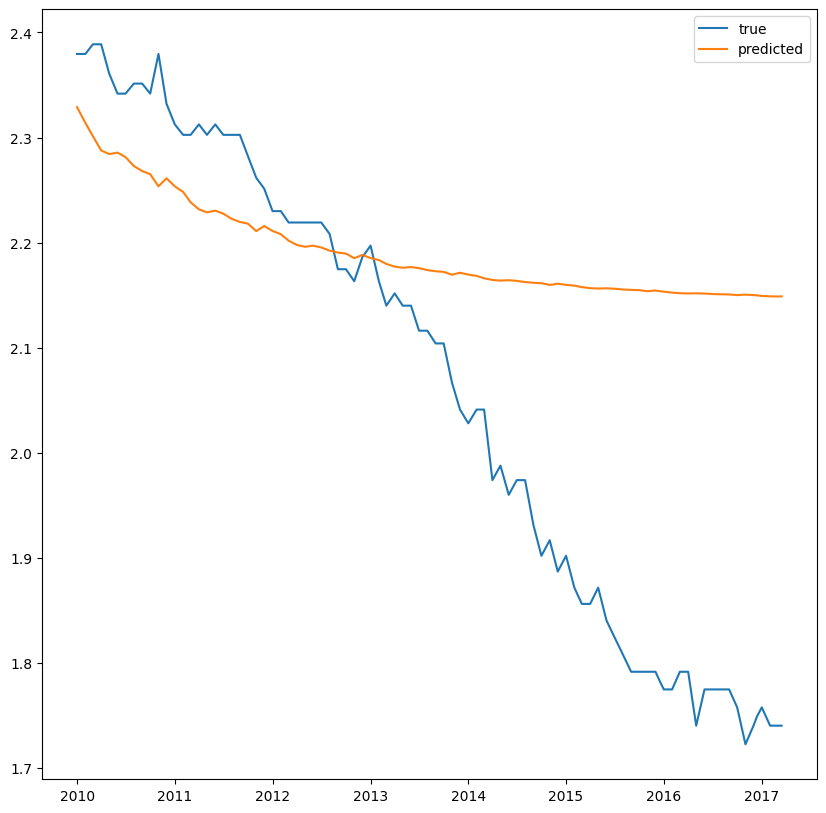

In [238]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.plot(test, label='true')
ax.plot(test.index, y_pred, label='predicted')
ax.legend()

In [239]:
X_lags = pd.DataFrame({f'lag_{i}': unempl_df.shift(i) for i in range(1, 6)}, index=unempl_df.index).dropna()

In [240]:
X_lags = X_lags.join(unempl_df)

In [241]:
X_train, X_test = X_lags.drop('Unemployment Rate', axis=1)[:'2010'], X_lags.drop('Unemployment Rate', axis=1)['2010':]
y_train, y_test = X_lags['Unemployment Rate'][:'2010'], X_lags['Unemployment Rate']['2010':]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

err = RMSLE(y_test, y_pred)
err_mape = MAPE(y_test, y_pred)

In [242]:
print('RMSLE SARIMAX', err)
print('MAPE SARIMAX', err_mape)

RMSLE SARIMAX 0.00647191339540857
MAPE SARIMAX 0.007377244088685204


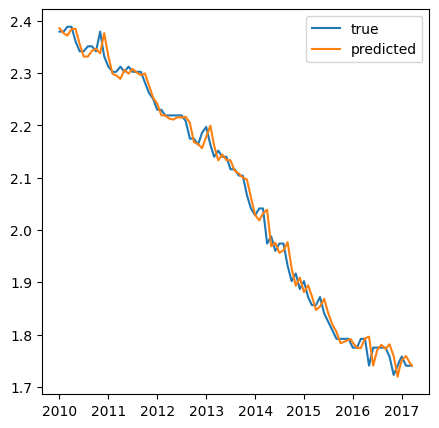

In [243]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(test, label='true')
ax.plot(test.index, y_pred, label='predicted')
ax.legend()

Very good MAPE and RMSLE, but looks like our predictor is lagging from the source and simply predicting the last value -> let's see whether we can try and incorporate the prior unemployment rate to help

In [244]:
X_lags = pd.DataFrame({f'lag_{i}': unempl_df.shift(i) for i in range(1, 6)}, index=unempl_df.index)
X_lags = X_lags.join(unempl_df).join(df['Inflation Rate'].interpolate(method='linear')).dropna()
X_train, X_test = X_lags.drop('Unemployment Rate', axis=1)[:'2010'], X_lags.drop('Unemployment Rate', axis=1)['2010':]
y_train, y_test = X_lags['Unemployment Rate'][:'2010'], X_lags['Unemployment Rate']['2010':]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

err = RMSLE(y_test, y_pred)
err_mape = MAPE(y_test, y_pred)

In [245]:
print('RMSLE LR', err)
print('MAPE LR', err_mape)

RMSLE LR 0.006404154347322981
MAPE LR 0.007511297246615893


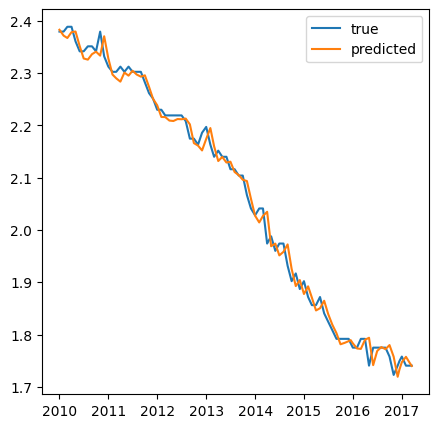

In [246]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.plot(test, label='true')
ax.plot(test.index, y_pred, label='predicted')
ax.legend()

In [247]:
## Seasonality Assessment

In [248]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    return ax

# seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# plot_periodogram(tunnel.NumVehicles);

# X["day"] = X.index.dayofweek  # the x-axis (freq)
# X["week"] = X.index.week  # the seasonal period (period)

# days within a year
# X["dayofyear"] = X.index.dayofyear
# X["year"] = X.index.year

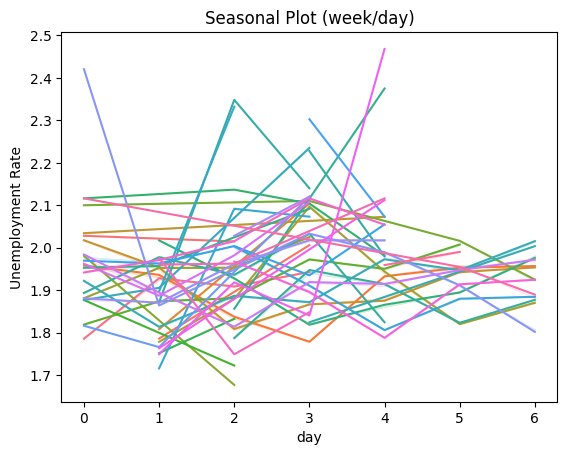

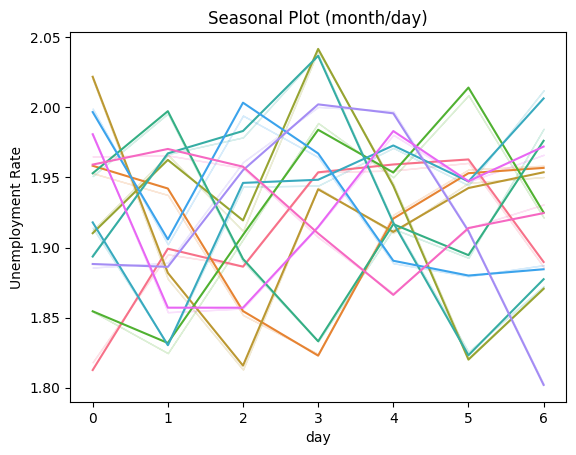

In [249]:
sp_df = pd.DataFrame(unempl_df)
sp_df["month"] = sp_df.index.month
sp_df["week"] = sp_df.index.week
sp_df["day"] = sp_df.index.dayofweek
_ = seasonal_plot(sp_df, 'Unemployment Rate', period="week", freq="day")
_ = seasonal_plot(sp_df, 'Unemployment Rate', period="month", freq="day")
## no apparent weekly/monthly seasonality

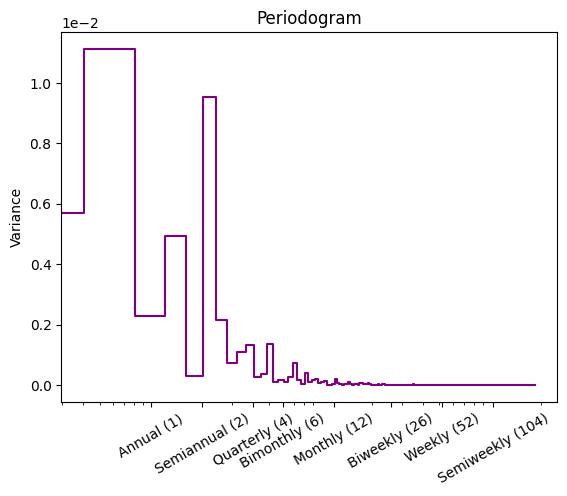

In [250]:
_ = plot_periodogram(sp_df['Unemployment Rate'])
## maybe some crazy long cyclic effect

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqgz4dii/85f5wgls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqgz4dii/d6jnpii8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9682', 'data', 'file=/tmp/tmpaqgz4dii/85f5wgls.json', 'init=/tmp/tmpaqgz4dii/d6jnpii8.json', 'output', 'file=/tmp/tmpaqgz4dii/prophet_modelrdvpr1hu/prophet_model-20231025212236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


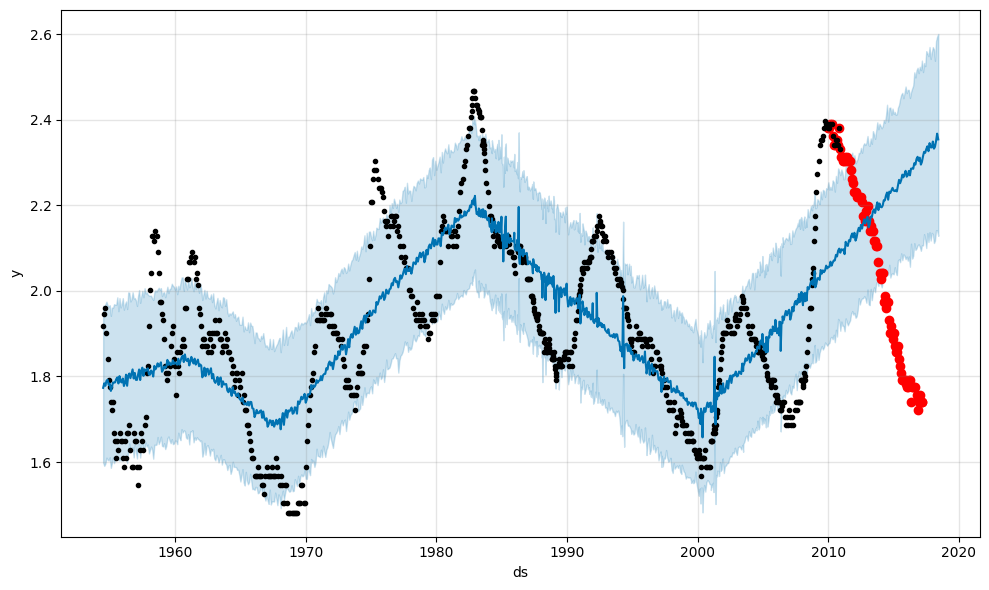

In [251]:
train, test = unempl_df[:'2010'], unempl_df['2010':]

train_prophet = pd.DataFrame({'ds': train.index, 'y':train.values})
prophet = Prophet()
prophet.fit(train_prophet)
future = prophet.make_future_dataframe(periods=len(test), freq='M')
forecast = prophet.predict(future)

ax = prophet.plot(forecast)
plt.scatter(test.index, test, color='r')

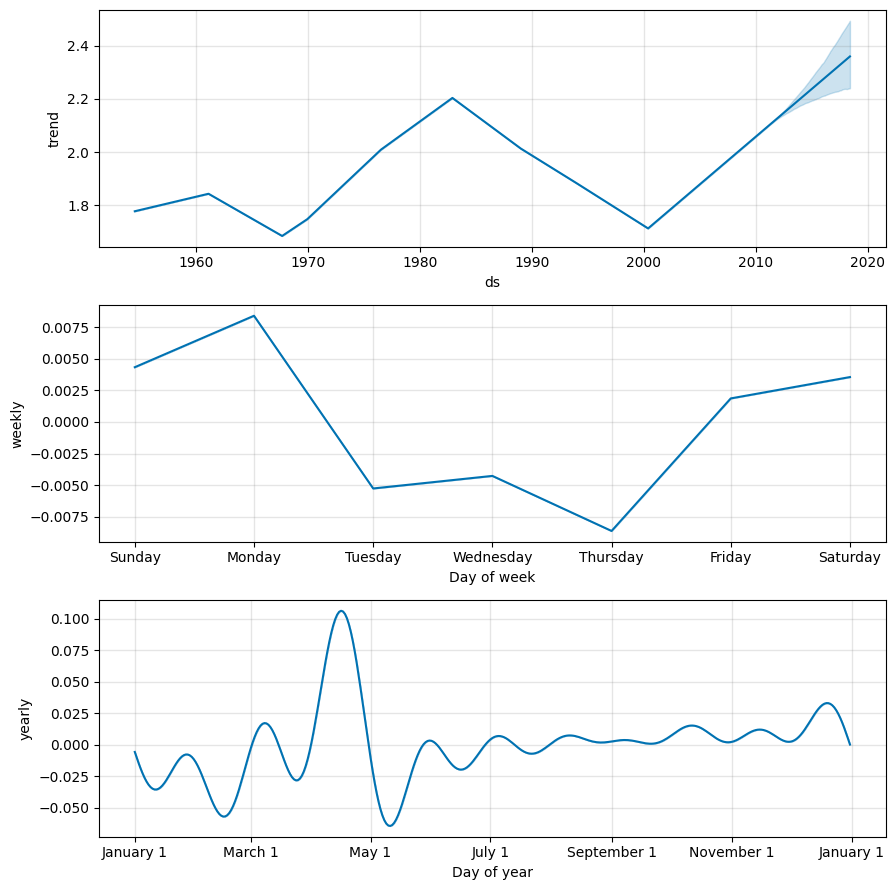

In [252]:
_ = prophet.plot_components(forecast)

Looks like there is very little seasonality to be honest, mostly is just noise - would need to supplant this prediction with additional data (news forecast, external measurements to get a leading value)

In [253]:
fourier = CalendarFourier(freq='A', order=4)
dp = DeterministicProcess(index=unempl_df.index, order=1, period=7, seasonal=True, additional_terms=[fourier])
X = dp.in_sample()
X_lags = pd.DataFrame({f'lag_{i}': unempl_df.shift(i) for i in range(1, 6)}, index=unempl_df.index)
X = X.join(X_lags).join(unempl_df).dropna()

In [254]:
X_train, X_test = X.drop('Unemployment Rate', axis=1)[:'2010'], X.drop('Unemployment Rate', axis=1)['2010':]
y_train, y_test = X['Unemployment Rate'][:'2010'], X['Unemployment Rate']['2010':]

In [255]:
def eval_model(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_preds = model.predict(X_test)
  return RMSLE(y_preds, y_test), MAPE(y_preds, y_test),

In [256]:
## Ridge Regression

for C in np.logspace(-2, 2, 9):
  rmsle, mape = eval_model(Ridge(alpha=C, random_state=42),  X_train, X_test, y_train, y_test)
  print(f'C= {C}, RMSLE = {rmsle}, MAPE = {mape}')

C= 0.01, RMSLE = 0.006684916846512971, MAPE = 0.007687026987221945
C= 0.03162277660168379, RMSLE = 0.006675279133137394, MAPE = 0.007683237896041247
C= 0.1, RMSLE = 0.0066844983071565256, MAPE = 0.007712897450551226
C= 0.31622776601683794, RMSLE = 0.006814994557077002, MAPE = 0.007807639481885661
C= 1.0, RMSLE = 0.007347896828425418, MAPE = 0.008372836236469108
C= 3.1622776601683795, RMSLE = 0.008547310152154645, MAPE = 0.009914623929067874
C= 10.0, RMSLE = 0.009882326615617915, MAPE = 0.011960094579557743
C= 31.622776601683793, RMSLE = 0.013711150791019557, MAPE = 0.01759615393657357
C= 100.0, RMSLE = 0.027665715968452905, MAPE = 0.03768772157182129


In [257]:
## Lasso Regression

for C in np.logspace(-2, 2, 9):
  rmsle, mape = eval_model(Lasso(alpha=C, random_state=42),  X_train, X_test, y_train, y_test)
  print(f'C= {C}, RMSLE = {rmsle}, MAPE = {mape}')

C= 0.01, RMSLE = 0.017719128961407, MAPE = 0.023662537935493364
C= 0.03162277660168379, RMSLE = 0.055472452834209124, MAPE = 0.07588509766325459
C= 0.1, RMSLE = 0.08031005995457587, MAPE = 0.11141967808225252
C= 0.31622776601683794, RMSLE = 0.080504516900392, MAPE = 0.11168758910447188
C= 1.0, RMSLE = 0.08114421779500336, MAPE = 0.11253739580167096
C= 3.1622776601683795, RMSLE = 0.08340822820819371, MAPE = 0.11525096052105609
C= 10.0, RMSLE = 0.08574953606059461, MAPE = 0.11791302139449866
C= 31.622776601683793, RMSLE = 0.08574953606059461, MAPE = 0.11791302139449866
C= 100.0, RMSLE = 0.08574953606059461, MAPE = 0.11791302139449866


In [258]:
## Polynomial Linear Regression

model = Pipeline(steps=[('poly', PolynomialFeatures()), ('linreg', LinearRegression())])
rmsle, mape = eval_model(model,  X_train, X_test, y_train, y_test)
print(f'C= {C}, RMSLE = {rmsle}, MAPE = {mape}')

C= 100.0, RMSLE = 0.014015715098630522, MAPE = 0.016445396483360016


In [259]:
## Kernalized Linear Regression

model = Pipeline(steps=[('kern', Nystroem(n_components=400, random_state=42)), ('linreg', LinearRegression())])
rmsle, mape = eval_model(model,  X_train, X_test, y_train, y_test)
print(f'C= {C}, RMSLE = {rmsle}, MAPE = {mape}')

C= 100.0, RMSLE = 0.06934938754990753, MAPE = 0.08875167712776336


In [260]:
## Random Forest Regressor

for min_samples_leaf in [5, 10, 20, 50, 100]:
  rmsle, mape = eval_model(RandomForestRegressor(n_estimators=300,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=1),  X_train, X_test, y_train, y_test)
  print(f'C= {C}, RMSLE = {rmsle}, MAPE = {mape}')

C= 100.0, RMSLE = 0.006516358994210771, MAPE = 0.007311357970766124
C= 100.0, RMSLE = 0.007259425149385713, MAPE = 0.008432862938243723
C= 100.0, RMSLE = 0.008223515218233795, MAPE = 0.00958125788266149
C= 100.0, RMSLE = 0.015896611414329895, MAPE = 0.018628642938652528
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414


In [261]:
for n_neighbors in range(100, 800, 100):
    auc = eval_model(KNeighborsRegressor(n_neighbors=n_neighbors,
                                                       weights='distance'), X_train, X_test, y_train, y_test)
    print(f'C= {C}, RMSLE = {rmsle}, MAPE = {mape}')

C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
C= 100.0, RMSLE = 0.0330959379033908, MAPE = 0.039975464748243414
